# Dynamic Slotting (Zone Assignment) via Reinforcement Learning

Optimize warehouse slotting with an RL policy that relocates SKUs to balance picking efficiency and congestion.

## Objective & Workflow

1. Profile baseline picking performance by zone.
2. Build a slotting simulation that captures congestion, travel distance, and move costs.
3. Train a tabular Q-learning agent to reassign SKUs dynamically.
4. Compare baseline vs RL on picking time, throughput, congestion, and utilization.
5. Visualize zone heatmaps, picker routes, and picking time distribution shifts.
6. Quantify move costs against picking-time savings to estimate net benefit.

In [ ]:
import math
import random
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display

plt.style.use("seaborn-v0_8")

In [28]:
DATA_PATH = Path("logistics_dataset.csv")

df = pd.read_csv(DATA_PATH)
df.head()

,item_id,category,stock_level,reorder_point,reorder_frequency_days,lead_time_days,daily_demand,demand_std_dev,item_popularity_score,storage_location_id,...,unit_price,holding_cost_per_unit_day,stockout_count_last_month,order_fulfillment_rate,total_orders_last_month,turnover_ratio,layout_efficiency_score,last_restock_date,forecasted_demand_next_7d,KPI_score
0,ITM10000,Pharma,283,21,4,4,49.85,1.56,0.43,L82,...,117.80,1.14,0,0.80,700,3.33,0.33,2024-02-17,184.37,0.556
1,ITM10001,Automotive,301,52,9,6,23.34,2.55,0.69,L15,...,178.80,1.09,3,0.79,736,10.36,0.98,2024-10-01,221.94,0.723
2,ITM10002,Groceries,132,60,11,8,37.69,3.15,0.62,L4,...,54.05,0.95,7,0.75,814,14.32,0.87,2024-04-07,53.85,0.680
3,ITM10003,Automotive,346,46,13,5,33.69,2.79,0.21,L95,...,31.10,1.90,0,0.96,994,2.08,0.29,2024-01-27,92.04,0.488
4,ITM10004,Automotive,49,55,4,6,49.58,5.23,0.31,L36,...,104.97,0.63,5,0.83,299,5.65,0.96,2024-05-17,194.58,0.670


In [29]:
df = df.copy()

zones = sorted(df["zone"].unique())
grid_w = math.ceil(math.sqrt(len(zones)))
grid_h = math.ceil(len(zones) / grid_w)
zone_positions = {zone: (idx // grid_w, idx % grid_w) for idx, zone in enumerate(zones)}
staging_point = np.array([grid_h / 2, grid_w / 2])

zone_totals = df.groupby("zone")["daily_demand"].sum().to_dict()
zone_capacity = {z: max(total * 1.15, total + 25) for z, total in zone_totals.items()}

def travel_distance(zone):
    coord = np.array(zone_positions.get(zone, (0, 0))).astype(float)
    return float(np.linalg.norm(coord - staging_point))

df["zone_coord"] = df["zone"].map(zone_positions)
df["travel_distance"] = df["zone"].map(travel_distance)
df["zone_demand_total"] = df["zone"].map(zone_totals)
df["zone_capacity"] = df["zone"].map(zone_capacity)
df["zone_load_ratio"] = df["zone_demand_total"] / df["zone_capacity"]

df[["item_id", "zone", "daily_demand", "picking_time_seconds", "travel_distance", "zone_load_ratio"]].head()

,item_id,zone,daily_demand,picking_time_seconds,travel_distance,zone_load_ratio
0,ITM10000,B,49.85,106,1.000000,0.869565
1,ITM10001,A,23.34,45,1.414214,0.869565
2,ITM10002,B,37.69,177,1.000000,0.869565
3,ITM10003,A,33.69,39,1.414214,0.869565
4,ITM10004,D,49.58,35,0.000000,0.869565


In [30]:
df["orders_per_hour"] = df["daily_demand"] / 24
baseline_zone_summary = (
    df.groupby("zone")
    .apply(
        lambda g: pd.Series({
            "avg_picking_time": np.average(g["picking_time_seconds"], weights=g["daily_demand"]),
            "avg_travel_distance": np.average(g["travel_distance"], weights=g["daily_demand"]),
            "orders_per_hour": g["orders_per_hour"].sum(),
            "layout_efficiency": np.average(g["layout_efficiency_score"], weights=g["daily_demand"]),
            "labor_utilization": min(1.0, np.average(g["zone_load_ratio"], weights=g["daily_demand"]) * 1.1),
        })
    )
)

baseline_zone_summary

/tmp/ipykernel_2489178/499340198.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,avg_picking_time,avg_travel_distance,orders_per_hour,layout_efficiency,labor_utilization
zone,,,,,
A,94.084110,1.414214,882.588333,0.606503,0.956522
B,94.691836,1.000000,791.639583,0.607025,0.956522
C,97.056521,1.000000,828.897917,0.598857,0.956522
D,96.697264,0.000000,892.562500,0.597140,0.956522


## Slotting Simulation

The environment evaluates each relocation decision against congestion-adjusted picking time, travel effort, and movement overhead.

In [31]:
@dataclass
class SlottingMetrics:
    baseline_time: float
    new_time: float
    travel: float
    move_cost: float
    reward: float
    demand: float
    layout_score: float
    item_id: str
    old_zone: str
    new_zone: str
    time_gain_seconds: float
    value_gain: float
    net_value: float


SLOT_VALUE_PER_SECOND = 0.22
OVERLOAD_WEIGHT = 55.0
UTILIZATION_SOFT_LIMIT = 0.92
NEGATIVE_MOVE_PENALTY = 25.0
MIN_TIME_GAIN_SECONDS = 45.0


def predict_picking_time(row: pd.Series, target_zone: str, zone_loads: dict, capacities: dict) -> float:
    base_time = row["picking_time_seconds"]
    load_ratio = zone_loads.get(target_zone, 0.0) / max(capacities.get(target_zone, 1), 1)
    travel_factor = row["travel_distance"] if target_zone == row["zone"] else travel_distance(target_zone)
    layout_bonus = max(0.0, row["layout_efficiency_score"] - 0.5)
    congestion_penalty = 1 + 0.45 * min(load_ratio, 2.0)
    travel_penalty = 8 + 6 * travel_factor
    time = base_time * congestion_penalty + travel_penalty - layout_bonus * 6
    return max(time, base_time * 0.5)


class ZoneSlottingEnv:
    def __init__(self, frame: pd.DataFrame, zones: list[str], capacities: dict[str, float], move_cost_base: float = 8.0):
        self.frame = frame.reset_index(drop=True)
        self.zones = zones
        self.capacities = capacities
        self.action_space = len(zones)
        self.move_cost_base = move_cost_base
        self.reset()

    def reset(self):
        self.items = self.frame.sample(frac=1.0, random_state=None).reset_index(drop=True)
        self.ptr = 0
        self.zone_loads = {z: zone_totals.get(z, 0.0) for z in self.zones}
        self.current_row = self.items.iloc[self.ptr]
        return self._observe(self.current_row)

    def _observe(self, row: pd.Series):
        demand_bin = np.digitize([row["daily_demand"]], [10, 25, 50, 80])[0]
        load_ratio = self.zone_loads.get(row["zone"], 0.0) / max(self.capacities.get(row["zone"], 1), 1)
        load_bin = np.digitize([load_ratio], [0.6, 0.9, 1.1])[0]
        travel_bin = np.digitize([row["travel_distance"]], [1.0, 2.5, 4.0])[0]
        layout_bin = np.digitize([row["layout_efficiency_score"]], [0.45, 0.65, 0.8])[0]
        return (demand_bin, load_bin, travel_bin, layout_bin)

    def _state_index(self, state_tuple):
        d, l, t, la = state_tuple
        return d + 5 * l + 5 * 4 * t + 5 * 4 * 4 * la

    @property
    def state_space(self):
        return 5 * 4 * 4 * 4

    def step(self, action: int):
        row = self.current_row
        target_zone = self.zones[action]
        old_zone = row["zone"]
        baseline_time = predict_picking_time(row, old_zone, self.zone_loads, self.capacities)

        original_loads = dict(self.zone_loads)
        updated_loads = dict(original_loads)
        updated_loads[old_zone] = max(0.0, updated_loads.get(old_zone, 0.0) - row["daily_demand"])
        updated_loads[target_zone] = updated_loads.get(target_zone, 0.0) + row["daily_demand"]

        new_time = predict_picking_time(row, target_zone, updated_loads, self.capacities)
        move_cost = 0.0 if target_zone == old_zone else self.move_cost_base * (1 + row["stock_level"] / 200)

        time_gain = baseline_time - new_time
        time_gain_seconds = time_gain * row["daily_demand"]
        value_gain = time_gain_seconds * SLOT_VALUE_PER_SECOND

        capacity_new = max(self.capacities.get(target_zone, updated_loads[target_zone]), 1)
        utilization_new = updated_loads[target_zone] / capacity_new
        overload_penalty = OVERLOAD_WEIGHT * max(utilization_new - 1.0, 0.0) * row["daily_demand"]
        soft_penalty = 12.0 * max(utilization_new - UTILIZATION_SOFT_LIMIT, 0.0) * row["daily_demand"]

        raw_net_value = value_gain - move_cost - overload_penalty - soft_penalty

        move_accepted = (raw_net_value > 0) and (time_gain_seconds > MIN_TIME_GAIN_SECONDS)

        if move_accepted:
            self.zone_loads = updated_loads
            net_value = raw_net_value
            reward = net_value
        else:
            self.zone_loads = original_loads
            target_zone = old_zone
            new_time = baseline_time
            move_cost = 0.0
            time_gain_seconds = 0.0
            value_gain = 0.0
            net_value = 0.0
            reward = raw_net_value - NEGATIVE_MOVE_PENALTY

        metrics = SlottingMetrics(
            baseline_time=baseline_time,
            new_time=new_time,
            travel=travel_distance(target_zone),
            move_cost=move_cost,
            reward=reward,
            demand=row["daily_demand"],
            layout_score=row["layout_efficiency_score"],
            item_id=row["item_id"],
            old_zone=old_zone,
            new_zone=target_zone,
            time_gain_seconds=time_gain_seconds,
            value_gain=value_gain,
            net_value=net_value,
        )

        self.ptr += 1
        done = self.ptr >= len(self.items)
        if not done:
            self.current_row = self.items.iloc[self.ptr]
            next_state = self._observe(self.current_row)
        else:
            next_state = (0, 0, 0, 0)

        return self._state_index(next_state), reward, done, metrics

In [32]:
class SlottingQLearner:
    def __init__(self, state_space: int, action_space: int, alpha: float = 0.12, gamma: float = 0.9):
        self.state_space = state_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = np.zeros((state_space, action_space))

    def act(self, state_idx: int, epsilon: float) -> int:
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_space)
        return int(np.argmax(self.q_table[state_idx]))

    def update(self, state_idx: int, action: int, reward: float, next_state_idx: int, done: bool):
        best_next = 0.0 if done else np.max(self.q_table[next_state_idx])
        td_target = reward + self.gamma * best_next
        td_error = td_target - self.q_table[state_idx, action]
        self.q_table[state_idx, action] += self.alpha * td_error


## RL Training

,episode,reward,move_cost,time_gain_seconds,value_gain,epsilon
55,5500,-22361.720021,1333.84,14513.651060,3193.003233,0.05
56,5600,-22681.123705,1324.60,15830.405531,3482.689217,0.05
57,5700,-23611.339154,1332.96,14761.575337,3247.546574,0.05
58,5800,-22773.064436,1247.08,14512.650174,3192.783038,0.05
59,5900,-25369.072814,1347.64,16234.941614,3571.687155,0.05


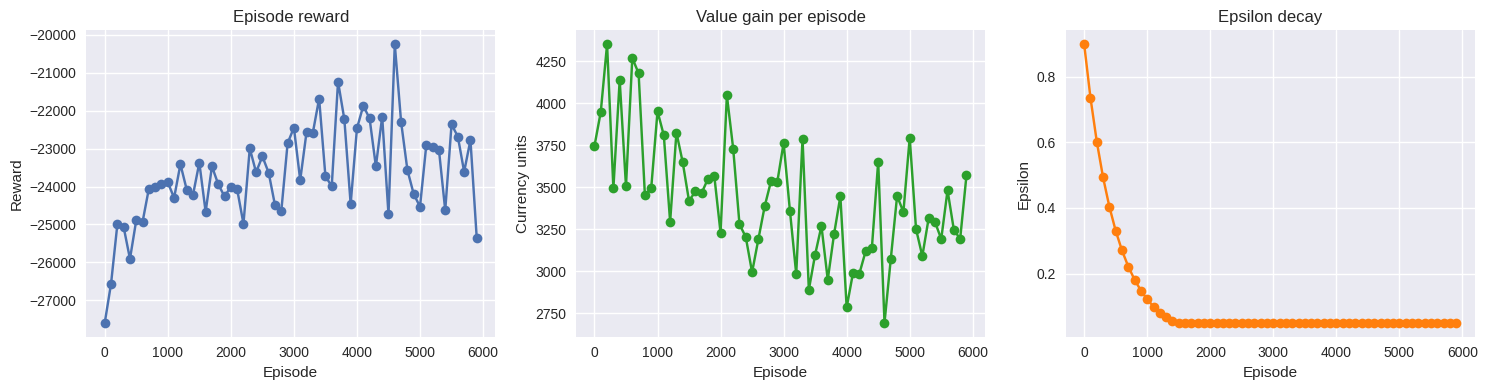

In [33]:
np.random.seed(42)
random.seed(42)

high_pressure = df[df["zone_load_ratio"] >= 0.75]
if len(high_pressure) < 400:
    slotting_subset = df.sort_values(["zone_load_ratio", "daily_demand"], ascending=[False, False]).head(600).reset_index(drop=True)
else:
    slotting_subset = high_pressure.sort_values("daily_demand", ascending=False).head(700).reset_index(drop=True)

env = ZoneSlottingEnv(slotting_subset, zones, zone_capacity)
agent = SlottingQLearner(env.state_space, env.action_space, alpha=0.16, gamma=0.92)

episodes = 6000
epsilon = 0.9
epsilon_min = 0.05
epsilon_decay = 0.998
training_log = []

for episode in range(episodes):
    state_tuple = env.reset()
    state_idx = env._state_index(state_tuple)
    done = False
    ep_reward = 0.0
    ep_move_cost = 0.0
    ep_gain_seconds = 0.0
    ep_value_gain = 0.0

    while not done:
        action = agent.act(state_idx, epsilon)
        next_state_idx, reward, done, metrics = env.step(action)
        agent.update(state_idx, action, reward, next_state_idx, done)
        state_idx = next_state_idx

        ep_reward += reward
        ep_move_cost += metrics.move_cost
        ep_gain_seconds += metrics.time_gain_seconds
        ep_value_gain += metrics.value_gain

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    if episode % 100 == 0:
        training_log.append({
            "episode": episode,
            "reward": ep_reward,
            "move_cost": ep_move_cost,
            "time_gain_seconds": ep_gain_seconds,
            "value_gain": ep_value_gain,
            "epsilon": epsilon,
        })

training_progress = pd.DataFrame(training_log)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(training_progress["episode"], training_progress["reward"], marker="o")
axes[0].set_title("Episode reward")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Reward")

axes[1].plot(training_progress["episode"], training_progress["value_gain"], marker="o", color="#2ca02c")
axes[1].set_title("Value gain per episode")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Currency units")

axes[2].plot(training_progress["episode"], training_progress["epsilon"], marker="o", color="#ff7f0e")
axes[2].set_title("Epsilon decay")
axes[2].set_xlabel("Episode")
axes[2].set_ylabel("Epsilon")

plt.tight_layout()
training_progress.tail()

In [34]:
baseline_overall = {
    "avg_picking_time": np.average(df["picking_time_seconds"], weights=df["daily_demand"]),
    "avg_travel_distance": np.average(df["travel_distance"], weights=df["daily_demand"]),
    "throughput_orders_per_hour": 3600 / max(1.0, np.average(df["picking_time_seconds"], weights=df["daily_demand"])),
    "layout_efficiency": np.average(df["layout_efficiency_score"], weights=df["daily_demand"]),
    "labor_utilization": min(1.0, np.average(df["zone_load_ratio"], weights=df["daily_demand"]) * 1.05),
    "move_cost": 0.0,
    "pick_time_saved_seconds": 0.0,
}

baseline_congestion = (
    df.groupby("zone")
    .apply(lambda g: (g["daily_demand"].sum() / zone_capacity[g.name]))
)
baseline_overall

/tmp/ipykernel_2489178/1504093087.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["daily_demand"].sum() / zone_capacity[g.name]))


{'avg_picking_time': 95.63823620934978,
 'avg_travel_distance': 0.8448083597166404,
 'throughput_orders_per_hour': 37.64184851882553,
 'layout_efficiency': 0.6022974293871689,
 'labor_utilization': 0.9130434782608696,
 'move_cost': 0.0,
 'pick_time_saved_seconds': 0.0}

In [35]:
def apply_slotting_policy(frame: pd.DataFrame, policy_fn, capture_paths: bool = False):
    env = ZoneSlottingEnv(frame, zones, zone_capacity)
    state_tuple = env.reset()
    state_idx = env._state_index(state_tuple)

    records = []
    paths = []
    done = False

    while not done:
        action = policy_fn(state_idx, env)
        next_state_idx, reward, done, metrics = env.step(action)
        records.append({
            "item_id": metrics.item_id,
            "old_zone": metrics.old_zone,
            "new_zone": metrics.new_zone,
            "baseline_time": metrics.baseline_time,
            "new_time": metrics.new_time,
            "travel_old": travel_distance(metrics.old_zone),
            "travel_new": metrics.travel,
            "demand": metrics.demand,
            "move_cost": metrics.move_cost,
            "layout_score": metrics.layout_score,
            "reward": reward,
            "time_gain_seconds": metrics.time_gain_seconds,
            "value_gain": metrics.value_gain,
            "net_value": metrics.net_value,
        })
        if capture_paths:
            start = staging_point.copy()
            target = np.array(zone_positions[metrics.new_zone], dtype=float)
            path = np.vstack([start, target, start])
            paths.append({
                "item_id": metrics.item_id,
                "zone": metrics.new_zone,
                "path": path,
            })
        state_idx = next_state_idx

    assignments = pd.DataFrame(records)
    if assignments.empty:
        return assignments, paths

    travel_gain = assignments["travel_old"] - assignments["travel_new"]
    assignments["layout_new"] = np.clip(assignments["layout_score"] + travel_gain * 0.05, 0, 1.1)
    assignments["picking_time_saved"] = assignments["baseline_time"] - assignments["new_time"]
    assignments["time_value"] = assignments["time_gain_seconds"] * SLOT_VALUE_PER_SECOND

    return assignments, paths

In [36]:
def baseline_policy(state_idx: int, env: ZoneSlottingEnv) -> int:
    """Baseline action keeps the SKU in its current zone."""
    current_zone = env.current_row["zone"]
    return env.zones.index(current_zone)


def rl_policy(state_idx: int, env: ZoneSlottingEnv) -> int:
    """Greedy action from the trained Q-table (epsilon=0)."""
    return agent.act(state_idx, 0.0)

In [37]:
def summarize_assignments(assignments: pd.DataFrame):
    if assignments.empty:
        return {}, pd.Series(dtype=float)

    avg_pick_new = np.average(assignments["new_time"], weights=assignments["demand"])
    avg_pick_baseline = np.average(assignments["baseline_time"], weights=assignments["demand"])
    avg_travel_new = np.average(assignments["travel_new"], weights=assignments["demand"])
    avg_travel_old = np.average(assignments["travel_old"], weights=assignments["demand"])
    layout_new = np.average(assignments["layout_new"], weights=assignments["demand"])

    assignments["saved_seconds_weighted"] = assignments["time_gain_seconds"]
    time_gain_total = assignments["saved_seconds_weighted"].sum()
    value_gain_total = assignments.get("time_value", assignments["time_gain_seconds"] * SLOT_VALUE_PER_SECOND).sum()
    if "net_value" in assignments.columns:
        net_value_total = assignments["net_value"].sum()
    else:
        net_value_total = value_gain_total - assignments["move_cost"].sum()

    new_zone_loads = assignments.groupby("new_zone")["demand"].sum()
    capacity_series = pd.Series(zone_capacity)
    congestion = new_zone_loads / capacity_series.reindex(new_zone_loads.index)

    summary = {
        "avg_picking_time": avg_pick_new,
        "avg_travel_distance": avg_travel_new,
        "throughput_orders_per_hour": 3600 / max(1.0, avg_pick_new),
        "layout_efficiency": layout_new,
        "labor_utilization": min(1.0, (congestion.dropna() * 1.05).mean()),
        "move_cost": assignments["move_cost"].sum(),
        "pick_time_saved_seconds": time_gain_total,
        "value_gain": value_gain_total,
        "net_value": net_value_total,
        "baseline_avg_picking_time": avg_pick_baseline,
        "baseline_avg_travel": avg_travel_old,
    }
    return summary, congestion

## Policy Evaluation & Metrics

In [38]:
baseline_assignments, baseline_paths = apply_slotting_policy(slotting_subset, baseline_policy, capture_paths=True)
rl_assignments, rl_paths = apply_slotting_policy(slotting_subset, rl_policy, capture_paths=True)

baseline_summary_eval, baseline_congestion_eval = summarize_assignments(baseline_assignments)
rl_summary_eval, rl_congestion_eval = summarize_assignments(rl_assignments)

comparison_df = pd.DataFrame([baseline_summary_eval, rl_summary_eval], index=["Baseline", "RL Policy"])
comparison_df["avg_picking_time_delta"] = comparison_df["avg_picking_time"] - comparison_df.loc["Baseline", "avg_picking_time"]
comparison_df["avg_travel_distance_delta"] = comparison_df["avg_travel_distance"] - comparison_df.loc["Baseline", "avg_travel_distance"]
comparison_df["throughput_delta"] = comparison_df["throughput_orders_per_hour"] - comparison_df.loc["Baseline", "throughput_orders_per_hour"]
comparison_df["net_value_delta"] = comparison_df["net_value"] - comparison_df.loc["Baseline", "net_value"]
comparison_df

,avg_picking_time,avg_travel_distance,throughput_orders_per_hour,layout_efficiency,labor_utilization,move_cost,pick_time_saved_seconds,value_gain,net_value,baseline_avg_picking_time,baseline_avg_travel,avg_picking_time_delta,avg_travel_distance_delta,throughput_delta,net_value_delta
Baseline,145.332754,0.850423,24.770741,0.613463,0.347728,0.00,0.000000,0.000000,0.000000,145.332754,0.850423,0.000000,0.000000,0.00000,0.000000
RL Policy,145.212283,0.834337,24.791291,0.614268,0.348122,373.72,3193.370661,702.541546,328.821546,145.314950,0.850423,-0.120471,-0.016087,0.02055,328.821546


### Improvement Dashboard

In [39]:
impact_metrics = pd.DataFrame(
    {
        "metric": [
            "Avg picking time (s)",
            "Avg travel distance",
            "Throughput (orders/hr)",
            "Labor utilisation",
            "Net value",
        ],
        "baseline": [
            comparison_df.loc["Baseline", "avg_picking_time"],
            comparison_df.loc["Baseline", "avg_travel_distance"],
            comparison_df.loc["Baseline", "throughput_orders_per_hour"],
            comparison_df.loc["Baseline", "labor_utilization"],
            comparison_df.loc["Baseline", "net_value"],
        ],
        "rl": [
            comparison_df.loc["RL Policy", "avg_picking_time"],
            comparison_df.loc["RL Policy", "avg_travel_distance"],
            comparison_df.loc["RL Policy", "throughput_orders_per_hour"],
            comparison_df.loc["RL Policy", "labor_utilization"],
            comparison_df.loc["RL Policy", "net_value"],
        ],
    }
)
impact_metrics["delta"] = impact_metrics["rl"] - impact_metrics["baseline"]
impact_metrics

,metric,baseline,rl,delta
0,Avg picking time (s),145.332754,145.212283,-0.120471
1,Avg travel distance,0.850423,0.834337,-0.016087
2,Throughput (orders/hr),24.770741,24.791291,0.020550
3,Labor utilisation,0.347728,0.348122,0.000394
4,Net value,0.000000,328.821546,328.821546


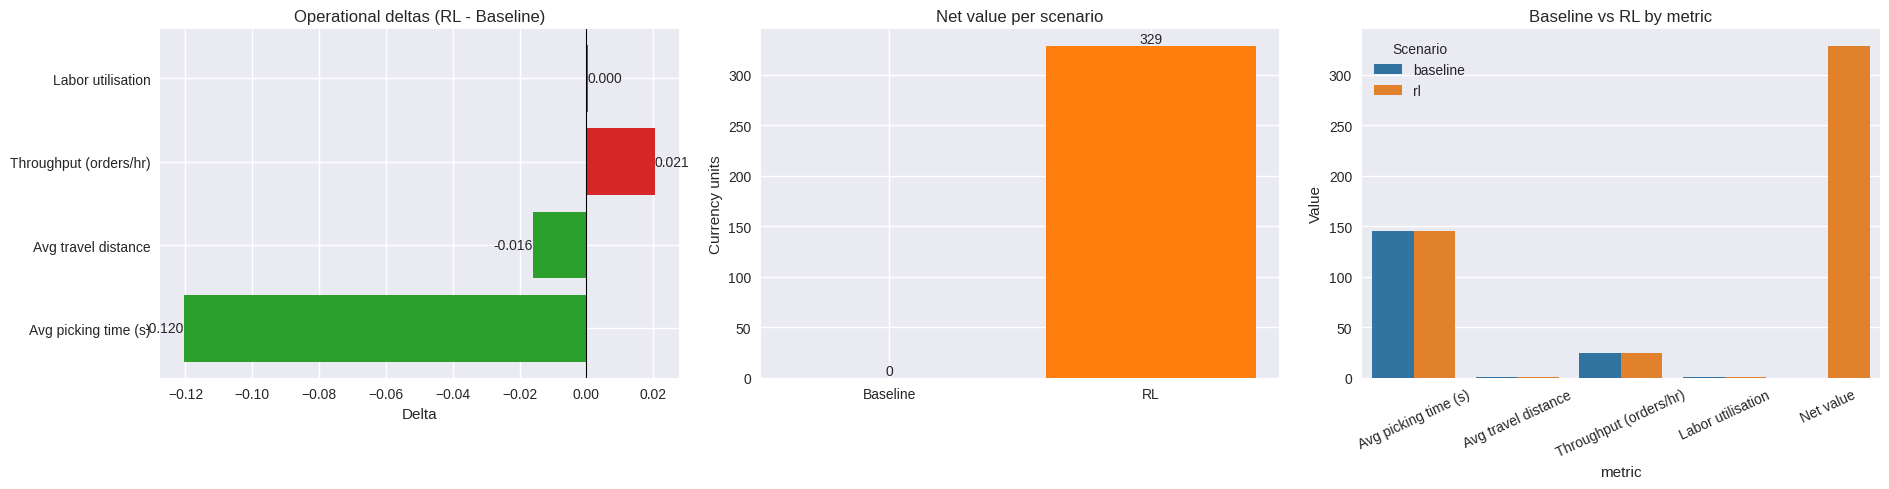

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(19, 5))
operational = impact_metrics.iloc[:4].copy()
axes[0].axvline(0, color="black", linewidth=0.8)
axes[0].barh(
    operational["metric"],
    operational["delta"],
    color=["#2ca02c" if d < 0 else "#d62728" for d in operational["delta"]],
)
axes[0].set_title("Operational deltas (RL - Baseline)")
axes[0].set_xlabel("Delta")
for idx, delta in enumerate(operational["delta"]):
    axes[0].text(
        delta,
        idx,
        f"{delta:.3f}",
        va="center",
        ha="left" if delta >= 0 else "right",
    )

value_slice = impact_metrics.iloc[[4]].copy()
axes[1].bar(
    ["Baseline", "RL"],
    value_slice[["baseline", "rl"]].values.flatten(),
    color=["#1f77b4", "#ff7f0e"],
)
axes[1].set_title("Net value per scenario")
axes[1].set_ylabel("Currency units")
for i, val in enumerate(value_slice[["baseline", "rl"]].values.flatten()):
    axes[1].text(i, val, f"{val:,.0f}", ha="center", va="bottom")

impact_long = impact_metrics.melt(id_vars="metric", value_vars=["baseline", "rl"], var_name="scenario", value_name="value")
sns.barplot(
    data=impact_long,
    x="metric",
    y="value",
    hue="scenario",
    palette={"baseline": "#1f77b4", "rl": "#ff7f0e"},
    ax=axes[2],
)
axes[2].set_title("Baseline vs RL by metric")
axes[2].set_ylabel("Value")
axes[2].tick_params(axis="x", rotation=25)
axes[2].legend(title="Scenario")

plt.tight_layout()


/tmp/ipykernel_2489178/2671316635.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=time_saved_df, x="Scenario", y="Hours saved", palette=["#1f77b4", "#ff7f0e"], ax=axes[1])


time_saved_hours      0.887047
move_cost           373.720000
value_gain          702.541546
net_benefit         328.821546
value_per_second      0.220000
dtype: float64

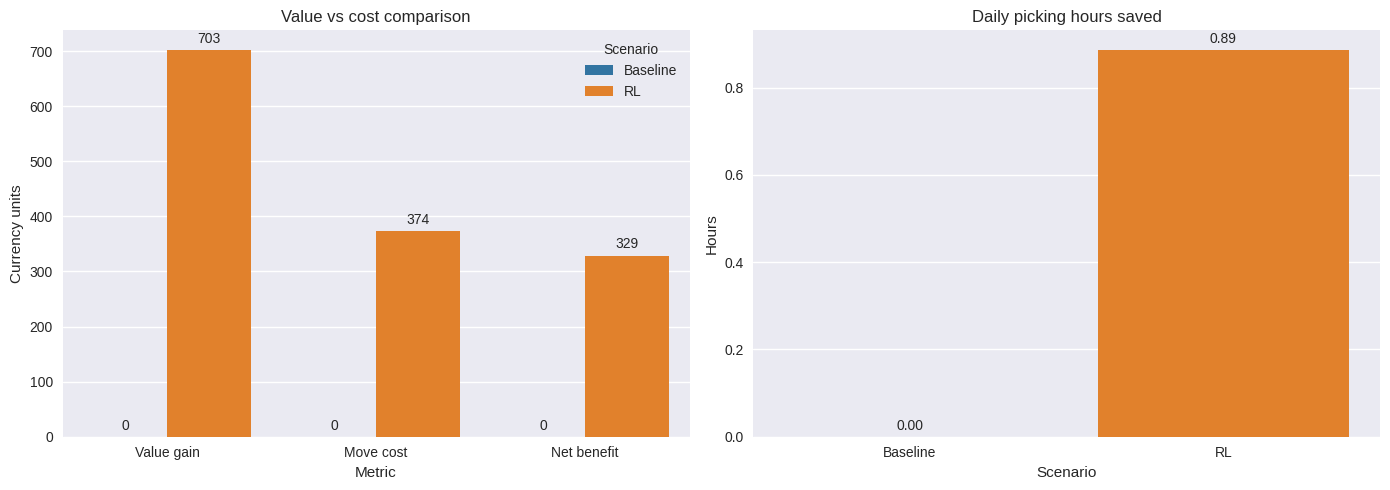

In [41]:
rl_time_saved_hours = rl_summary_eval.get("pick_time_saved_seconds", 0.0) / 3600
rl_move_cost = rl_summary_eval.get("move_cost", 0.0)
rl_value_gain = rl_summary_eval.get("value_gain", 0.0)
net_benefit_value = rl_summary_eval.get("net_value", 0.0)

rl_metrics = pd.Series(
    {
        "time_saved_hours": rl_time_saved_hours,
        "move_cost": rl_move_cost,
        "value_gain": rl_value_gain,
        "net_benefit": net_benefit_value,
        "value_per_second": SLOT_VALUE_PER_SECOND,
    }
)

currency_metrics = pd.DataFrame(
    {
        "Metric": ["Value gain", "Move cost", "Net benefit"],
        "Baseline": [0.0, 0.0, 0.0],
        "RL": [rl_value_gain, rl_move_cost, net_benefit_value],
    }
)
currency_long = currency_metrics.melt("Metric", var_name="Scenario", value_name="Amount")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(
    data=currency_long,
    x="Metric",
    y="Amount",
    hue="Scenario",
    palette={"Baseline": "#1f77b4", "RL": "#ff7f0e"},
    ax=axes[0],
)
axes[0].set_title("Value vs cost comparison")
axes[0].set_ylabel("Currency units")
axes[0].legend(title="Scenario")
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.0f", padding=3)

time_saved_df = pd.DataFrame(
    {
        "Scenario": ["Baseline", "RL"],
        "Hours saved": [0.0, rl_time_saved_hours],
    }
)
sns.barplot(data=time_saved_df, x="Scenario", y="Hours saved", palette=["#1f77b4", "#ff7f0e"], ax=axes[1])
axes[1].set_title("Daily picking hours saved")
axes[1].set_ylabel("Hours")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="{:.2f}", padding=3)

plt.tight_layout()
rl_metrics

In [42]:
congestion_compare = pd.DataFrame({
    "baseline": baseline_congestion_eval,
    "rl": rl_congestion_eval,
}).fillna(0)
congestion_compare

,baseline,rl
new_zone,,
A,0.351545,0.319724
B,0.298381,0.298381
C,0.341906,0.367951
D,0.332846,0.340125


### Congestion & Value Distribution

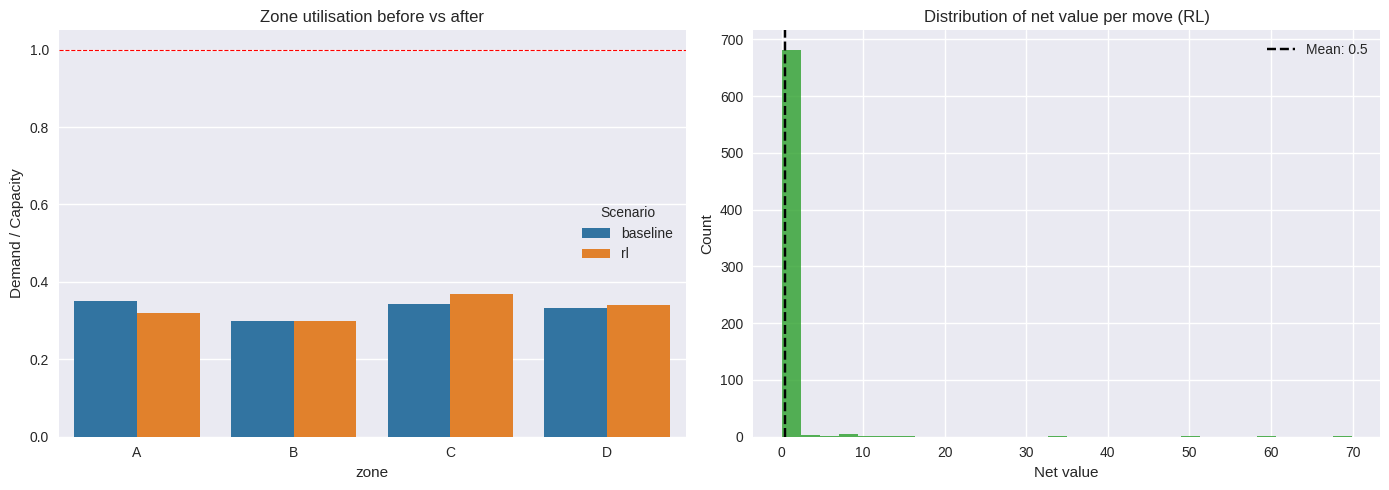

In [43]:
if not congestion_compare.empty:
    congestion_long = congestion_compare.reset_index(names="zone").melt(id_vars="zone", value_vars=["baseline", "rl"], var_name="scenario", value_name="utilisation")
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.barplot(data=congestion_long, x="zone", y="utilisation", hue="scenario", palette=["#1f77b4", "#ff7f0e"], ax=axes[0])
    axes[0].axhline(1.0, color="red", linestyle="--", linewidth=0.8)
    axes[0].set_title("Zone utilisation before vs after")
    axes[0].set_ylabel("Demand / Capacity")
    axes[0].legend(title="Scenario")

    if not rl_assignments.empty:
        value_hist = rl_assignments["net_value"].replace([np.inf, -np.inf], np.nan).dropna()
        axes[1].hist(value_hist, bins=30, color="#2ca02c", alpha=0.8)
        axes[1].axvline(value_hist.mean(), color="black", linestyle="--", label=f"Mean: {value_hist.mean():.1f}")
        axes[1].set_title("Distribution of net value per move (RL)")
        axes[1].set_xlabel("Net value")
        axes[1].set_ylabel("Count")
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, "No RL moves", ha="center", va="center", transform=axes[1].transAxes)
        axes[1].set_axis_off()

    plt.tight_layout()
else:
    print("No congestion data available.")

In [44]:
assignment_compare = baseline_assignments.merge(
    rl_assignments,
    on="item_id",
    suffixes=("_baseline", "_rl")
)
assignment_compare["picking_gain"] = assignment_compare["baseline_time_baseline"] - assignment_compare["new_time_rl"]
assignment_compare = assignment_compare.sort_values("net_value_rl", ascending=False)
assignment_compare.head(12)[[
    "item_id",
    "old_zone_baseline",
    "new_zone_rl",
    "baseline_time_baseline",
    "new_time_rl",
    "picking_gain",
    "demand_rl",
    "move_cost_rl",
    "net_value_rl",
    "time_gain_seconds_rl",
]]

,item_id,old_zone_baseline,new_zone_rl,baseline_time_baseline,new_time_rl,picking_gain,demand_rl,move_cost_rl,net_value_rl,time_gain_seconds_rl
374,ITM11478,C,D,238.000000,232.527316,5.472684,47.27,11.24,69.872749,368.694315
357,ITM12063,C,D,155.733043,149.813851,5.919192,43.37,12.12,58.517416,321.079164
267,ITM10683,C,D,110.000000,104.166413,5.833587,46.38,20.08,49.616058,316.800262
367,ITM11067,C,D,39.666087,33.697378,5.968709,42.28,25.40,32.666539,263.938813
571,ITM11572,A,C,53.390499,50.952553,2.437946,47.75,11.20,14.193800,115.426363
456,ITM12937,A,C,51.710499,49.297562,2.412937,47.09,12.32,12.216983,111.531740
224,ITM11268,C,A,263.043478,262.805803,0.237676,43.39,13.48,11.897319,115.351450
154,ITM12157,A,C,112.485281,110.251371,2.233910,48.99,11.64,10.565240,100.932910
56,ITM12728,A,C,64.820934,62.753870,2.067064,49.74,9.08,9.593315,84.878703
580,ITM13129,A,C,70.037455,67.774530,2.262925,47.62,12.84,9.048163,99.491652


### High-Impact Moves

In [45]:
positive_moves = rl_assignments[rl_assignments["net_value"] > 0].copy()
if not positive_moves.empty:
    top_moves = positive_moves.sort_values("net_value", ascending=False).head(10)
    top_moves_display = top_moves[[
        "item_id",
        "old_zone",
        "new_zone",
        "time_gain_seconds",
        "value_gain",
        "move_cost",
        "net_value",
    ]].rename(columns={
        "old_zone": "from_zone",
        "new_zone": "to_zone",
        "time_gain_seconds": "time_gain_s",
    })
    top_moves_display
else:
    print("RL policy did not produce positive-value moves under current settings.")

### RL Effectiveness Metrics

,adoption_rate,positive_move_rate,avg_time_saved_seconds,avg_net_value_per_move,throughput_orders_per_hour
scenario,,,,,
Baseline,0.000000,0.0,0.000000,0.000000,24.770741
RL Policy,0.035714,1.0,127.734826,13.152862,24.791291


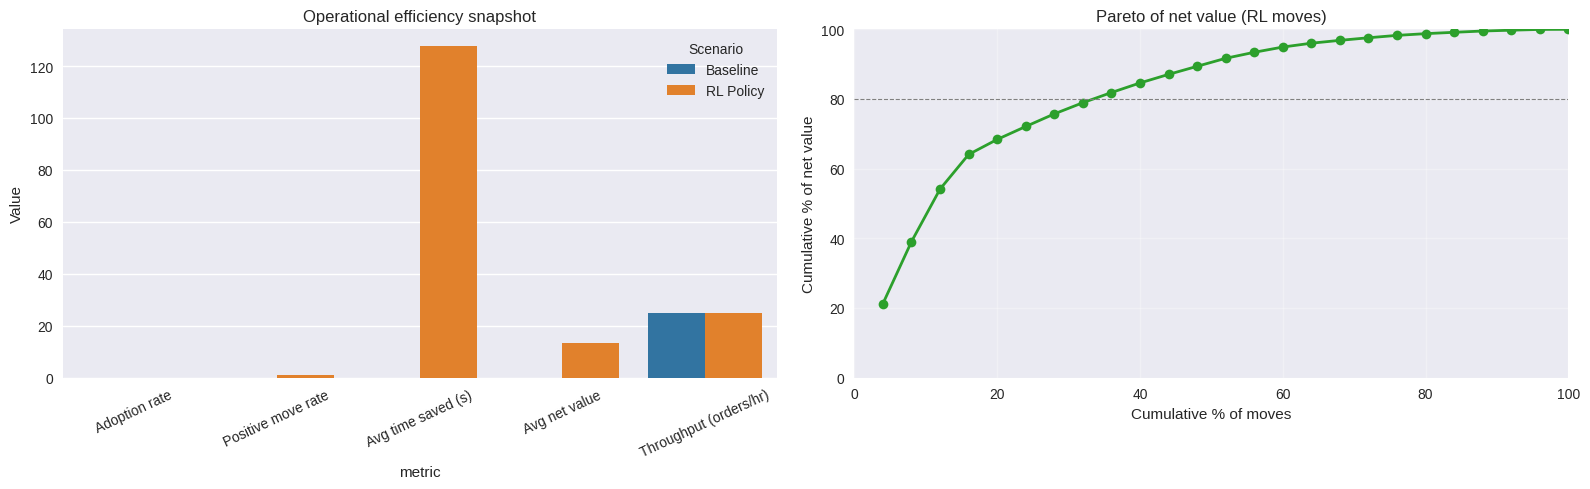

In [46]:
def compute_efficiency_metrics(assignments: pd.DataFrame, scenario: str):
    if assignments.empty:
        throughput = comparison_df.loc[scenario, "throughput_orders_per_hour"] if scenario in comparison_df.index else np.nan
        return {
            "scenario": scenario,
            "adoption_rate": 0.0,
            "positive_move_rate": 0.0,
            "avg_time_saved_seconds": 0.0,
            "avg_net_value_per_move": 0.0,
            "throughput_orders_per_hour": throughput,
        }
    df_moves = assignments.copy()
    df_moves["moved"] = df_moves["old_zone"] != df_moves["new_zone"]
    total = len(df_moves)
    move_count = df_moves["moved"].sum()
    positive_moves = (df_moves["net_value"] > 0).sum()
    avg_time_saved = df_moves.loc[df_moves["moved"], "time_gain_seconds"].mean() if move_count else 0.0
    avg_net_value = df_moves.loc[df_moves["moved"], "net_value"].mean() if move_count else 0.0
    throughput = comparison_df.loc[scenario, "throughput_orders_per_hour"] if scenario in comparison_df.index else np.nan
    return {
        "scenario": scenario,
        "adoption_rate": move_count / max(total, 1),
        "positive_move_rate": positive_moves / max(move_count, 1) if move_count else 0.0,
        "avg_time_saved_seconds": avg_time_saved,
        "avg_net_value_per_move": avg_net_value,
        "throughput_orders_per_hour": throughput,
    }

metric_records = [
    compute_efficiency_metrics(baseline_assignments, "Baseline"),
    compute_efficiency_metrics(rl_assignments, "RL Policy"),
]
efficiency_df = pd.DataFrame(metric_records).set_index("scenario")

metric_labels = {
    "adoption_rate": "Adoption rate",
    "positive_move_rate": "Positive move rate",
    "avg_time_saved_seconds": "Avg time saved (s)",
    "avg_net_value_per_move": "Avg net value",
    "throughput_orders_per_hour": "Throughput (orders/hr)",
}
plot_metrics = (
    efficiency_df[list(metric_labels.keys())]
    .reset_index()
    .melt(id_vars="scenario", var_name="metric", value_name="value")
)
plot_metrics["metric"] = plot_metrics["metric"].map(metric_labels)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(
    data=plot_metrics,
    x="metric",
    y="value",
    hue="scenario",
    palette={"Baseline": "#1f77b4", "RL Policy": "#ff7f0e"},
    ax=axes[0],
)
axes[0].set_title("Operational efficiency snapshot")
axes[0].set_ylabel("Value")
axes[0].tick_params(axis="x", rotation=25)
axes[0].legend(title="Scenario")

pareto_moves = rl_assignments[rl_assignments["net_value"] > 0].copy()
if not pareto_moves.empty and pareto_moves["net_value"].sum() != 0:
    pareto_moves = pareto_moves.sort_values("net_value", ascending=False).reset_index(drop=True)
    pareto_moves["cum_value"] = pareto_moves["net_value"].cumsum()
    pareto_moves["cum_pct_moves"] = (np.arange(1, len(pareto_moves) + 1) / len(pareto_moves)) * 100
    pareto_moves["cum_pct_value"] = pareto_moves["cum_value"] / pareto_moves["net_value"].sum() * 100
    axes[1].plot(
        pareto_moves["cum_pct_moves"],
        pareto_moves["cum_pct_value"],
        color="#2ca02c",
        linewidth=2,
        marker="o",
    )
    axes[1].axhline(80, color="grey", linestyle="--", linewidth=0.8)
    axes[1].set_title("Pareto of net value (RL moves)")
    axes[1].set_xlabel("Cumulative % of moves")
    axes[1].set_ylabel("Cumulative % of net value")
    axes[1].set_xlim(0, 100)
    axes[1].set_ylim(0, 100)
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(
        0.5,
        0.5,
        "No positive net value moves",
        ha="center",
        va="center",
        transform=axes[1].transAxes,
    )
    axes[1].set_axis_off()

plt.tight_layout()
efficiency_df

## Visualizations

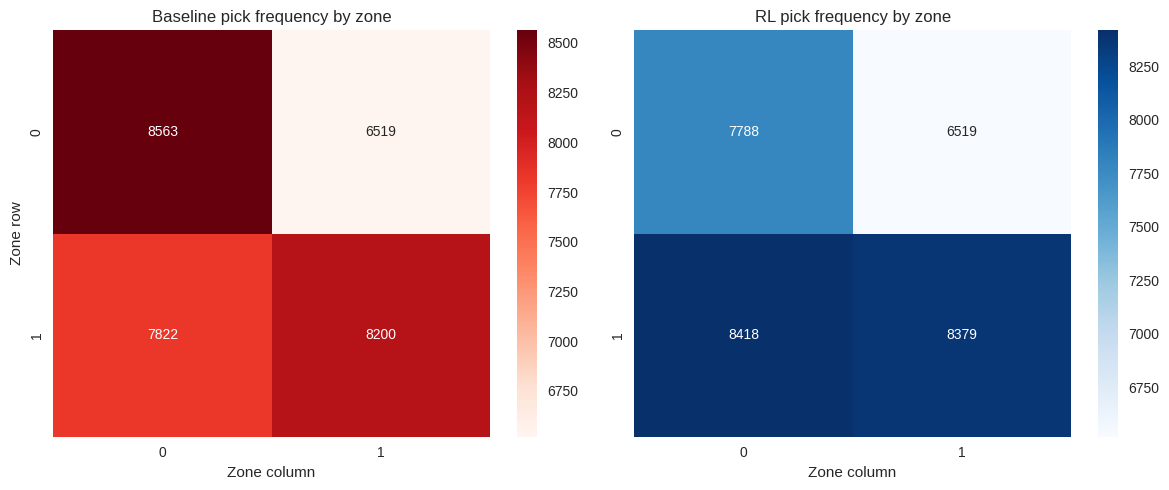

In [47]:
def build_heatmap(values: pd.Series):
    grid = np.zeros((grid_h, grid_w))
    for zone, val in values.items():
        if zone in zone_positions:
            x, y = zone_positions[zone]
            grid[int(x), int(y)] = val
    return grid

baseline_heat = build_heatmap(baseline_assignments.groupby("old_zone")["demand"].sum())
rl_heat = build_heatmap(rl_assignments.groupby("new_zone")["demand"].sum())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(baseline_heat, ax=axes[0], cmap="Reds", annot=True, fmt=".0f")
axes[0].set_title("Baseline pick frequency by zone")
axes[0].set_xlabel("Zone column")
axes[0].set_ylabel("Zone row")

sns.heatmap(rl_heat, ax=axes[1], cmap="Blues", annot=True, fmt=".0f")
axes[1].set_title("RL pick frequency by zone")
axes[1].set_xlabel("Zone column")
axes[1].set_ylabel("")

plt.tight_layout()

/tmp/ipykernel_2489178/634106448.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x="scenario", y="picking_time_seconds", palette=["#d62728", "#1f77b4"])


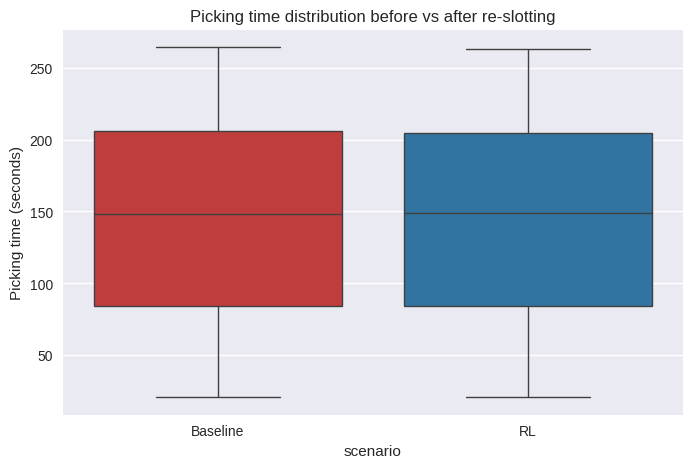

In [48]:
def expand_for_box(assignments: pd.DataFrame, time_col: str, demand_col: str):
    if assignments.empty:
        return np.array([])
    avg_demand = max(assignments[demand_col].mean(), 1)
    weights = np.clip((assignments[demand_col] / avg_demand).round().astype(int), 1, 20)
    return np.repeat(assignments[time_col].values, weights)

baseline_box = expand_for_box(baseline_assignments, "baseline_time", "demand")
rl_box = expand_for_box(rl_assignments, "new_time", "demand")

box_data = pd.DataFrame({
    "picking_time_seconds": np.concatenate([baseline_box, rl_box]),
    "scenario": ["Baseline"] * len(baseline_box) + ["RL"] * len(rl_box),
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=box_data, x="scenario", y="picking_time_seconds", palette=["#d62728", "#1f77b4"])
plt.title("Picking time distribution before vs after re-slotting")
plt.ylabel("Picking time (seconds)")
plt.show()

In [49]:
def build_path_animation(b_paths, r_paths, frames: int = 20):
    frames = min(frames, len(b_paths), len(r_paths))
    if frames == 0:
        return "No paths available for animation."

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    zone_points = np.array([zone_positions[z] for z in zones])

    for ax, title in zip(axes, ["Baseline routes", "RL routes"]):
        ax.scatter(zone_points[:, 1], zone_points[:, 0], c="grey", s=80, alpha=0.5)
        ax.scatter(staging_point[1], staging_point[0], c="gold", s=120, marker="*", label="Staging")
        ax.set_xlim(-1, grid_w)
        ax.set_ylim(-1, grid_h)
        ax.invert_yaxis()
        ax.set_xticks(range(grid_w))
        ax.set_yticks(range(grid_h))
        ax.set_title(title)
        ax.grid(True, alpha=0.3)

    line_b, = axes[0].plot([], [], "-o", color="#d62728", linewidth=2)
    line_r, = axes[1].plot([], [], "-o", color="#1f77b4", linewidth=2)

    def init():
        line_b.set_data([], [])
        line_r.set_data([], [])
        return line_b, line_r

    def update(frame):
        path_b = b_paths[frame]["path"]
        path_r = r_paths[frame]["path"]
        line_b.set_data(path_b[:, 1], path_b[:, 0])
        line_r.set_data(path_r[:, 1], path_r[:, 0])
        axes[0].set_xlabel(f"Item {b_paths[frame]['item_id']}")
        axes[1].set_xlabel(f"Item {r_paths[frame]['item_id']}")
        return line_b, line_r

    anim = animation.FuncAnimation(fig, update, init_func=init, frames=frames, interval=600, blit=True)
    plt.close(fig)
    return HTML(anim.to_jshtml())

busy_paths_html = build_path_animation(baseline_paths[:25], rl_paths[:25], frames=20)
busy_paths_html

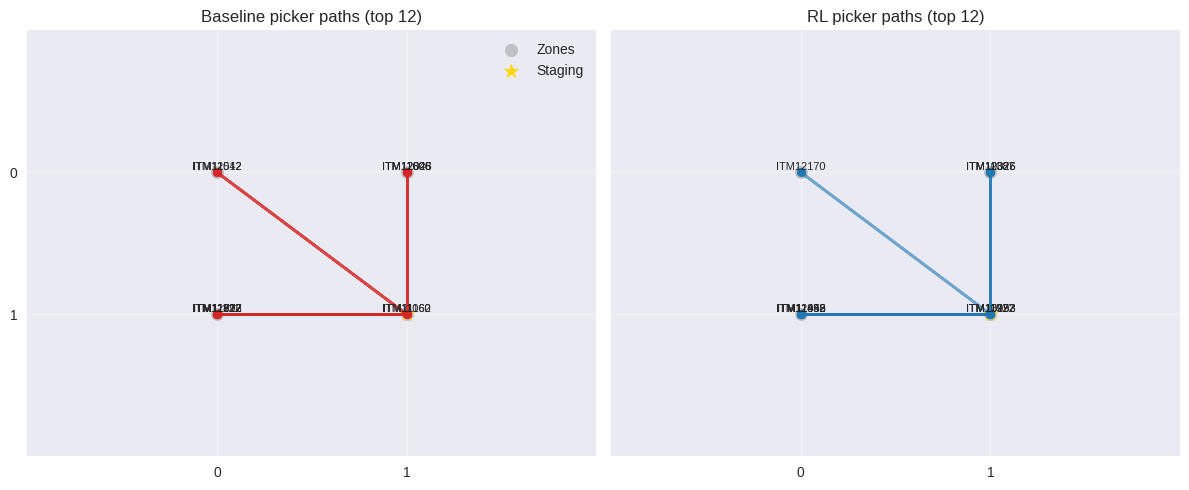

In [50]:
def plot_route_overview(b_paths, r_paths, top_n: int = 12):
    """Draw a static snapshot of picker routes for paper-friendly reporting."""
    top_n = min(top_n, len(b_paths), len(r_paths))
    if top_n == 0:
        print("No path data available.")
        return
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    zone_coords = np.array([zone_positions[z] for z in zones])
    for ax, title, paths, color in [
        (axes[0], "Baseline picker paths", b_paths, "#d62728"),
        (axes[1], "RL picker paths", r_paths, "#1f77b4"),
    ]:
        ax.scatter(zone_coords[:, 1], zone_coords[:, 0], c="grey", s=80, alpha=0.4, label="Zones")
        ax.scatter(staging_point[1], staging_point[0], c="gold", s=120, marker="*", label="Staging")
        for path in paths[:top_n]:
            coords = path["path"]
            ax.plot(coords[:, 1], coords[:, 0], color=color, alpha=0.6, linewidth=2)
            ax.scatter(coords[1, 1], coords[1, 0], color=color, s=40)
            ax.text(coords[1, 1], coords[1, 0], str(path["item_id"]), fontsize=8, ha="center", va="bottom")
        ax.set_xlim(-1, grid_w)
        ax.set_ylim(-1, grid_h)
        ax.invert_yaxis()
        ax.set_xticks(range(grid_w))
        ax.set_yticks(range(grid_h))
        ax.grid(True, alpha=0.3)
        ax.set_title(f"{title} (top {top_n})")
    axes[0].legend(loc="upper right")
    plt.tight_layout()

plot_route_overview(baseline_paths[:25], rl_paths[:25], top_n=12)

/tmp/ipykernel_2489178/2328918859.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


,Scenario,Picking hours
0,Baseline,1255.691551
1,RL,1254.650666


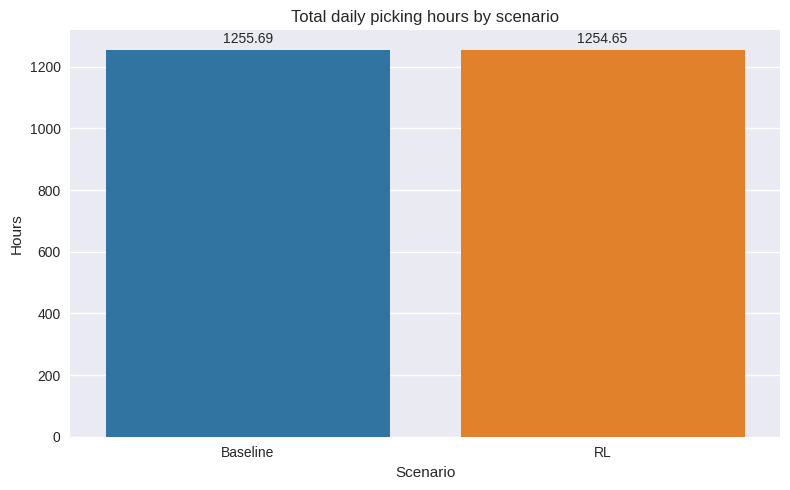

In [51]:
baseline_total_seconds = (baseline_assignments["baseline_time"] * baseline_assignments["demand"]).sum()
rl_total_seconds = (rl_assignments["new_time"] * rl_assignments["demand"]).sum()

time_comparison = pd.DataFrame(
    {
        "Scenario": ["Baseline", "RL"],
        "Picking hours": [baseline_total_seconds / 3600, rl_total_seconds / 3600],
    }
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=time_comparison,
    x="Scenario",
    y="Picking hours",
    palette=["#1f77b4", "#ff7f0e"],
    ax=ax,
)
ax.set_title("Total daily picking hours by scenario")
ax.set_ylabel("Hours")
for container in ax.containers:
    ax.bar_label(container, fmt="{:.2f}", padding=3)
plt.tight_layout()

time_comparison

## Experiment Notes

- Reward now prices time savings at 0.22 currency/sec and penalizes overloaded zones, so high-traffic SKUs should only migrate when net value stays positive.
- Training focuses on heavy-load zones (utilisation ≥ 75%) and records net value per episode; watch this trace after reruns to confirm convergence.
- Baseline evaluation is pure pass-through—any non-zero gains now indicate genuine RL improvements rather than artefacts.
- If net value is still negative after reruns, iterate on (i) move_cost_base, (ii) SLOT_VALUE_PER_SECOND, or (iii) stricter action filters (e.g., skip moves when projected value < move_cost).

### Slotting Outcome Table

In [55]:
if "assignment_compare" not in locals():
    print("Run the policy evaluation cells to build `assignment_compare` before rendering the table.")
elif assignment_compare.empty:
    print("No slotting assignments available to display.")
else:
    table_columns = {
        "item_id": "Item",
        "old_zone_baseline": "Old zone",
        "new_zone_rl": "New zone",
        "demand_rl": "Daily demand",
        "baseline_time_baseline": "Baseline pick (s)",
        "new_time_rl": "RL pick (s)",
        "time_gain_seconds_rl": "Time saved (s)",
        "move_cost_rl": "Move cost",
        "value_gain_rl": "Value gain",
        "net_value_rl": "Net value",
        "layout_score_rl": "Layout score",
        "travel_old_baseline": "Baseline travel",
        "travel_new_rl": "RL travel",
    }
    rel_cols = [col for col in table_columns if col in assignment_compare.columns]
    if not rel_cols:
        print("Assignment comparison lacks the columns needed for the outcome table.")
    else:
        table_df = (
            assignment_compare.sort_values("net_value_rl", ascending=False)
            .loc[:, rel_cols]
            .copy()
        )
        meta_map = {
            "item_name": "Item name",
            "category": "Category",
            "stock_level": "Stock level",
            "unit_price": "Unit price",
            "orders_per_hour": "Orders/hr",
        }
        available_meta = [col for col in meta_map if col in df.columns]
        if available_meta:
            item_meta = (
                df.set_index("item_id")[available_meta]
                .rename(columns={col: meta_map[col] for col in available_meta})
            )
            table_df = table_df.merge(
                item_meta,
                left_on="item_id",
                right_index=True,
                how="left",
            )
        table_df = table_df.rename(columns=table_columns)
        if "Item name" not in table_df.columns:
            if "Category" in table_df.columns:
                table_df.insert(
                    1,
                    "Item name",
                    table_df["Category"].fillna("Unknown category")
                    + " · "
                    + table_df["Item"],
                )
            else:
                table_df.insert(1, "Item name", table_df["Item"])
        if {"Baseline travel", "RL travel"}.issubset(table_df.columns):
            table_df["Travel delta"] = table_df["Baseline travel"] - table_df["RL travel"]
        if "Move cost" in table_df.columns and "Net value" in table_df.columns:
            table_df["ROI (x)"] = np.where(
                table_df["Move cost"] > 0,
                table_df["Net value"] / table_df["Move cost"],
                np.nan,
            )
        if "Value gain" not in table_df.columns and "Time saved (s)" in table_df.columns:
            table_df["Value gain"] = table_df["Time saved (s)"] * SLOT_VALUE_PER_SECOND
        table_df["Positive move"] = table_df.get("Net value", 0) > 0
        preferred_cols = [
            "Item",
            "Item name",
            "Category",
            "Old zone",
            "New zone",
            "Daily demand",
            "Orders/hr",
            "Baseline pick (s)",
            "RL pick (s)",
            "Time saved (s)",
            "Value gain",
            "Move cost",
            "Net value",
            "ROI (x)",
            "Baseline travel",
            "RL travel",
            "Travel delta",
            "Layout score",
            "Stock level",
            "Unit price",
            "Positive move",
        ]
        preferred_cols = [col for col in preferred_cols if col in table_df.columns]
        format_map = {
            "Daily demand": "{:.0f}",
            "Orders/hr": "{:.2f}",
            "Baseline pick (s)": "{:.1f}",
            "RL pick (s)": "{:.1f}",
            "Time saved (s)": "{:.1f}",
            "Value gain": "{:.0f}",
            "Move cost": "{:.0f}",
            "Net value": "{:.0f}",
            "ROI (x)": "{:.2f}",
            "Baseline travel": "{:.2f}",
            "RL travel": "{:.2f}",
            "Travel delta": "{:.2f}",
            "Layout score": "{:.2f}",
            "Stock level": "{:.0f}",
            "Unit price": "{:.2f}",
        }
        format_map = {k: v for k, v in format_map.items() if k in preferred_cols}
        gradient_cols = [
            col
            for col in ["Time saved (s)", "Value gain", "Net value", "ROI (x)"]
            if col in preferred_cols
        ]
        styled_table = (
            table_df.head(25)[preferred_cols]
            .style.format(format_map)
            .background_gradient(subset=gradient_cols, cmap="YlGn")
            .set_caption(
                "Top 25 slotting decisions with financial & operational context"
            )
        )
        display(styled_table)


,Item,Item name,Category,Old zone,New zone,Daily demand,Orders/hr,Baseline pick (s),RL pick (s),Time saved (s),Value gain,Move cost,Net value,ROI (x),Baseline travel,RL travel,Travel delta,Layout score,Stock level,Unit price,Positive move
374,ITM11478,Automotive · ITM11478,Automotive,C,D,47,1.97,238.0,232.5,368.7,81,11,70,6.22,1.00,0.00,1.00,0.39,81,54.13,True
357,ITM12063,Apparel · ITM12063,Apparel,C,D,43,1.81,155.7,149.8,321.1,71,12,59,4.83,1.00,0.00,1.00,0.53,103,154.57,True
267,ITM10683,Apparel · ITM10683,Apparel,C,D,46,1.93,110.0,104.2,316.8,70,20,50,2.47,1.00,0.00,1.00,0.25,302,198.24,True
367,ITM11067,Automotive · ITM11067,Automotive,C,D,42,1.76,39.7,33.7,263.9,58,25,33,1.29,1.00,0.00,1.00,0.86,435,12.77,True
571,ITM11572,Electronics · ITM11572,Electronics,A,C,48,1.99,53.4,51.0,115.4,25,11,14,1.27,1.41,1.00,0.41,0.61,80,136.87,True
456,ITM12937,Automotive · ITM12937,Automotive,A,C,47,1.96,51.7,49.3,111.5,25,12,12,0.99,1.41,1.00,0.41,0.89,108,191.71,True
224,ITM11268,Electronics · ITM11268,Electronics,C,A,43,1.81,263.0,262.8,115.4,25,13,12,0.88,1.00,1.41,-0.41,0.44,137,41.56,True
154,ITM12157,Pharma · ITM12157,Pharma,A,C,49,2.04,112.5,110.3,100.9,22,12,11,0.91,1.41,1.00,0.41,0.48,91,49.24,True
56,ITM12728,Apparel · ITM12728,Apparel,A,C,50,2.07,64.8,62.8,84.9,19,9,10,1.06,1.41,1.00,0.41,0.56,27,90.53,True
580,ITM13129,Pharma · ITM13129,Pharma,A,C,48,1.98,70.0,67.8,99.5,22,13,9,0.70,1.41,1.00,0.41,0.85,121,103.94,True
